# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [24]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [25]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [26]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [27]:
def encoder_block(input_layer, filters, strides=1):
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer = separable_conv2d_batchnorm(input_layer, filters=filters, strides=strides)
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [28]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    Upsampled_small_ip_layer = bilinear_upsample(small_ip_layer)
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    concatenated_layers = layers.concatenate([Upsampled_small_ip_layer,large_ip_layer])
    # TODO Add some number of separable convolution layers
    output_layer = encoder_block(concatenated_layers,filters=filters, strides=1)
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [29]:
def fcn_model(inputs, num_classes):
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    print(inputs.get_shape())
    #Layer 1
    layer_1 = encoder_block(inputs, filters=32, strides=2)
    print(layer_1.get_shape())
    #Layer 2
    layer_2 = encoder_block(layer_1, filters=64, strides=2)
    print(layer_2.get_shape())
    layer_3 = encoder_block(layer_2, filters=128, strides=2)
    print(layer_3.get_shape())
    layer_4 = encoder_block(layer_3, filters=256, strides=2)
    print(layer_4.get_shape())
    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    layer_1x1 = conv2d_batchnorm(layer_4, filters=1028, kernel_size=1, strides=1)    
    print(layer_1x1.get_shape())
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    decoder_1 = decoder_block(layer_1x1, layer_3, filters=128)
    print(decoder_1.get_shape())
    decoder_2 = decoder_block(decoder_1, layer_2, filters=64)
    print(decoder_2.get_shape())
    decoder_3 = decoder_block(decoder_2, layer_1, filters=32)
    print(decoder_3.get_shape())
    x = decoder_block(decoder_3, inputs, filters=num_classes)    
    print(x.get_shape())
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(x)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [30]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)
#print(output_layer.get_shape())

(?, 160, 160, 3)
(?, 80, 80, 32)
(?, 40, 40, 64)
(?, 20, 20, 128)
(?, 10, 10, 256)
(?, 10, 10, 1028)
(?, 20, 20, 128)
(?, 40, 40, 64)
(?, 80, 80, 32)
(?, 160, 160, 3)


### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [87]:
learning_rate = 0.001
batch_size = 10
num_epochs = 100
steps_per_epoch = 30
validation_steps = 50
workers = 2

Epoch 1/100
29/30 [============================>.] - ETA: 2s - loss: 0.0368

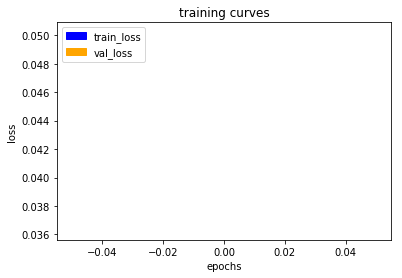

30/30 [==============================] - 94s - loss: 0.0363 - val_loss: 0.0502
Epoch 2/100
29/30 [============================>.] - ETA: 2s - loss: 0.0477

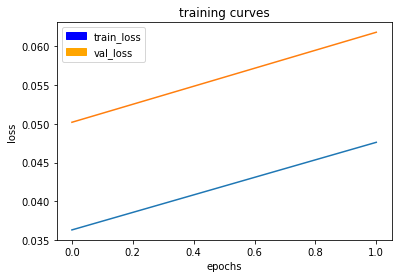

30/30 [==============================] - 88s - loss: 0.0476 - val_loss: 0.0618
Epoch 3/100
29/30 [============================>.] - ETA: 2s - loss: 0.0478

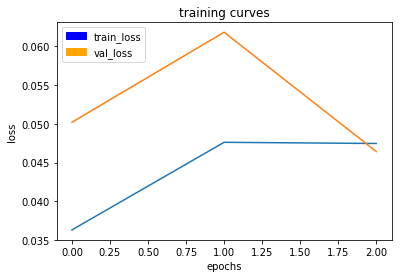

30/30 [==============================] - 91s - loss: 0.0475 - val_loss: 0.0464
Epoch 4/100
29/30 [============================>.] - ETA: 2s - loss: 0.0463

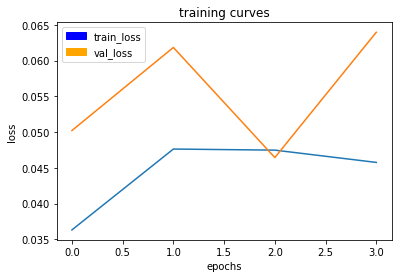

30/30 [==============================] - 89s - loss: 0.0458 - val_loss: 0.0640
Epoch 5/100
29/30 [============================>.] - ETA: 2s - loss: 0.0455

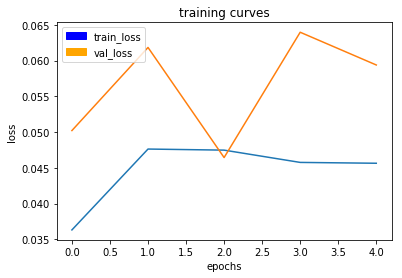

30/30 [==============================] - 89s - loss: 0.0456 - val_loss: 0.0594
Epoch 6/100
29/30 [============================>.] - ETA: 2s - loss: 0.0342

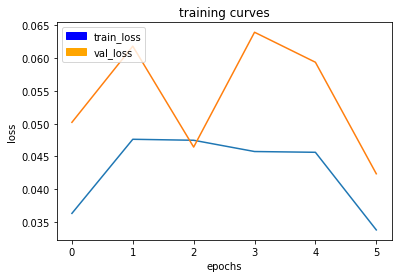

30/30 [==============================] - 90s - loss: 0.0338 - val_loss: 0.0424
Epoch 7/100
29/30 [============================>.] - ETA: 2s - loss: 0.0321

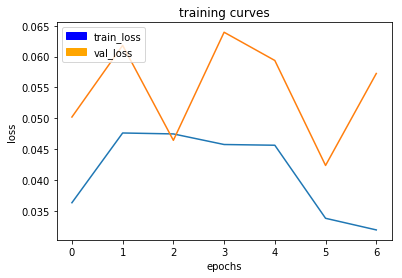

30/30 [==============================] - 90s - loss: 0.0319 - val_loss: 0.0573
Epoch 8/100
29/30 [============================>.] - ETA: 2s - loss: 0.0409

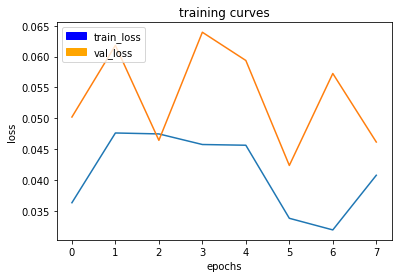

30/30 [==============================] - 94s - loss: 0.0408 - val_loss: 0.0462
Epoch 9/100
29/30 [============================>.] - ETA: 2s - loss: 0.0322

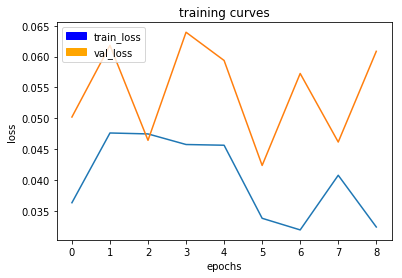

30/30 [==============================] - 89s - loss: 0.0324 - val_loss: 0.0609
Epoch 10/100
29/30 [============================>.] - ETA: 2s - loss: 0.0355

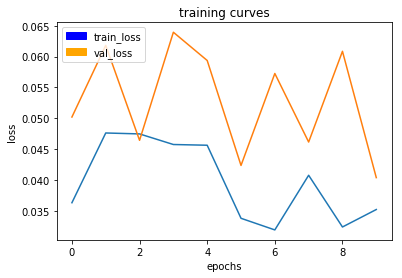

30/30 [==============================] - 88s - loss: 0.0352 - val_loss: 0.0404
Epoch 11/100
29/30 [============================>.] - ETA: 2s - loss: 0.0349

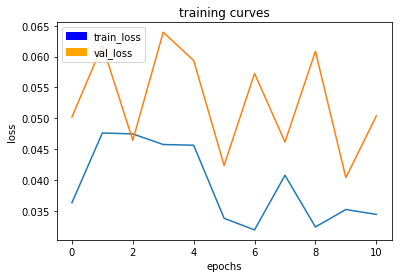

30/30 [==============================] - 89s - loss: 0.0344 - val_loss: 0.0504
Epoch 12/100
29/30 [============================>.] - ETA: 2s - loss: 0.0425

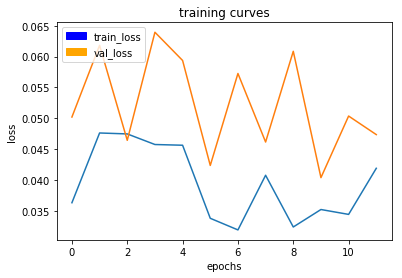

30/30 [==============================] - 87s - loss: 0.0419 - val_loss: 0.0474
Epoch 13/100
29/30 [============================>.] - ETA: 2s - loss: 0.0401

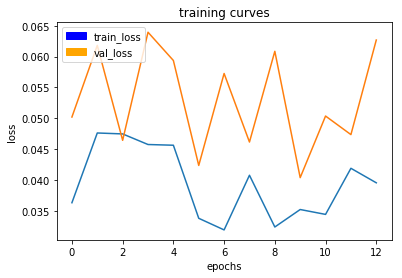

30/30 [==============================] - 87s - loss: 0.0395 - val_loss: 0.0627
Epoch 14/100
29/30 [============================>.] - ETA: 2s - loss: 0.0344

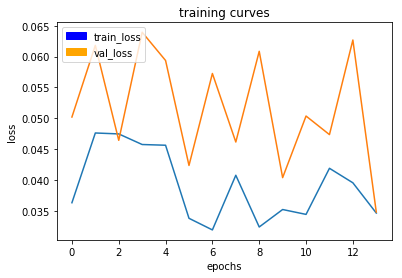

30/30 [==============================] - 89s - loss: 0.0343 - val_loss: 0.0348
Epoch 15/100
29/30 [============================>.] - ETA: 2s - loss: 0.0514

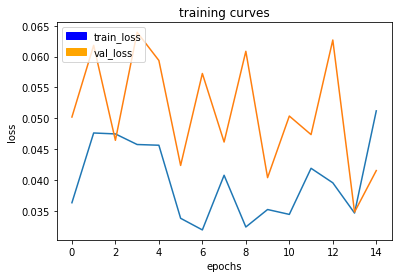

30/30 [==============================] - 88s - loss: 0.0512 - val_loss: 0.0415
Epoch 16/100
29/30 [============================>.] - ETA: 2s - loss: 0.0301

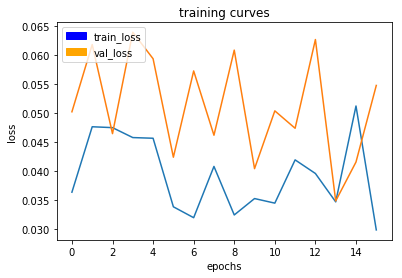

30/30 [==============================] - 87s - loss: 0.0298 - val_loss: 0.0548
Epoch 17/100
29/30 [============================>.] - ETA: 2s - loss: 0.0379

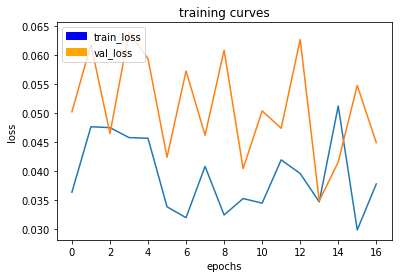

30/30 [==============================] - 88s - loss: 0.0377 - val_loss: 0.0449
Epoch 18/100
29/30 [============================>.] - ETA: 2s - loss: 0.0341

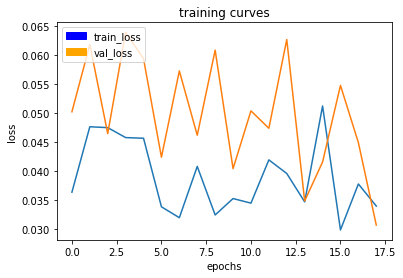

30/30 [==============================] - 87s - loss: 0.0339 - val_loss: 0.0306
Epoch 19/100
29/30 [============================>.] - ETA: 2s - loss: 0.0367

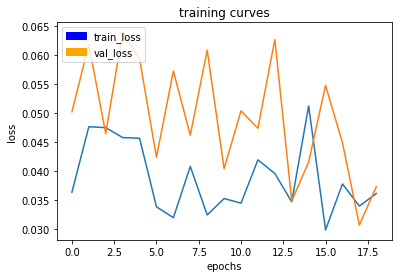

30/30 [==============================] - 87s - loss: 0.0361 - val_loss: 0.0373
Epoch 20/100
29/30 [============================>.] - ETA: 2s - loss: 0.0353

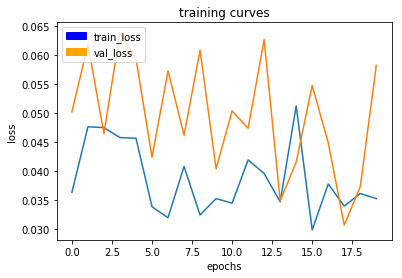

30/30 [==============================] - 87s - loss: 0.0352 - val_loss: 0.0582
Epoch 21/100
29/30 [============================>.] - ETA: 2s - loss: 0.0301

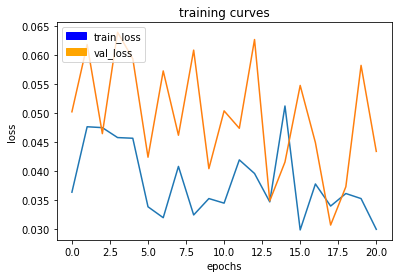

30/30 [==============================] - 91s - loss: 0.0299 - val_loss: 0.0434
Epoch 22/100
29/30 [============================>.] - ETA: 2s - loss: 0.0277

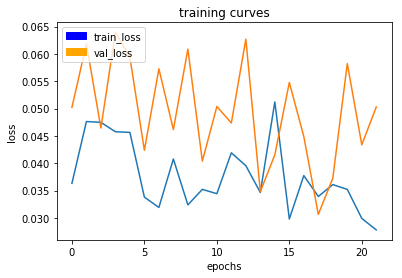

30/30 [==============================] - 89s - loss: 0.0278 - val_loss: 0.0503
Epoch 23/100
29/30 [============================>.] - ETA: 2s - loss: 0.0473

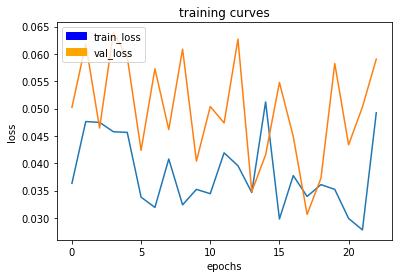

30/30 [==============================] - 91s - loss: 0.0492 - val_loss: 0.0591
Epoch 24/100
29/30 [============================>.] - ETA: 2s - loss: 0.0370

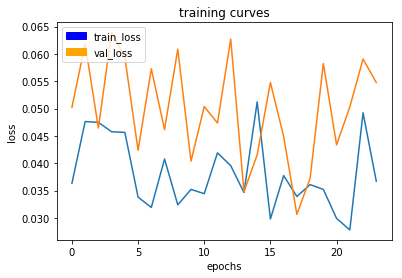

30/30 [==============================] - 87s - loss: 0.0367 - val_loss: 0.0548
Epoch 25/100
29/30 [============================>.] - ETA: 2s - loss: 0.0363

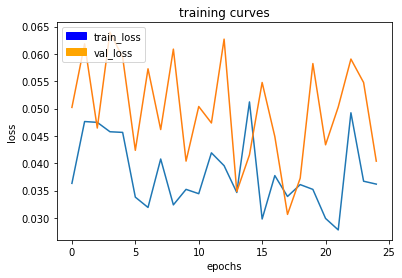

30/30 [==============================] - 90s - loss: 0.0362 - val_loss: 0.0404
Epoch 26/100
29/30 [============================>.] - ETA: 2s - loss: 0.0307

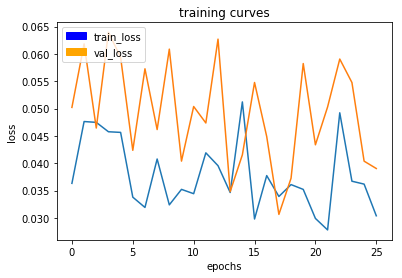

30/30 [==============================] - 92s - loss: 0.0304 - val_loss: 0.0390
Epoch 27/100
29/30 [============================>.] - ETA: 2s - loss: 0.0387

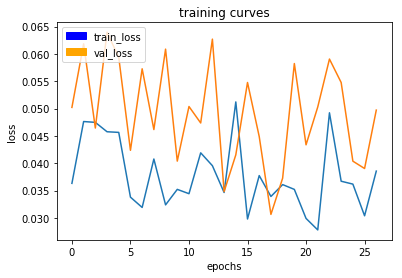

30/30 [==============================] - 92s - loss: 0.0386 - val_loss: 0.0497
Epoch 28/100
29/30 [============================>.] - ETA: 2s - loss: 0.0303

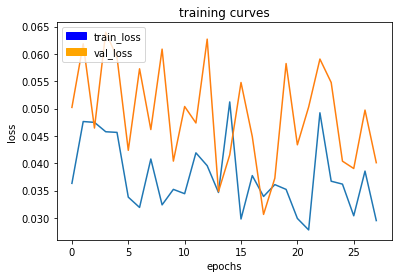

30/30 [==============================] - 86s - loss: 0.0299 - val_loss: 0.0401
Epoch 29/100
29/30 [============================>.] - ETA: 2s - loss: 0.0393

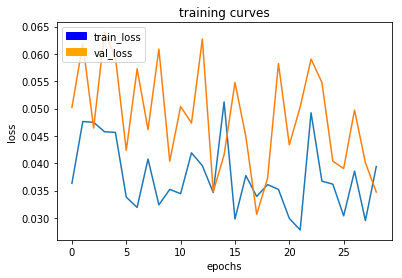

30/30 [==============================] - 88s - loss: 0.0394 - val_loss: 0.0347
Epoch 30/100
29/30 [============================>.] - ETA: 2s - loss: 0.0352

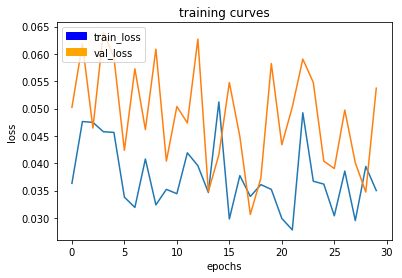

30/30 [==============================] - 88s - loss: 0.0350 - val_loss: 0.0537
Epoch 31/100
29/30 [============================>.] - ETA: 2s - loss: 0.0289

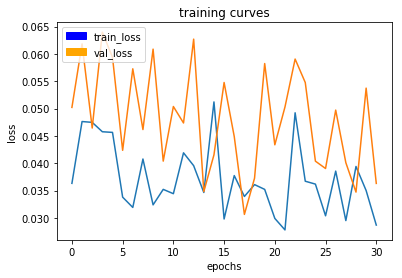

30/30 [==============================] - 88s - loss: 0.0287 - val_loss: 0.0363
Epoch 32/100
29/30 [============================>.] - ETA: 2s - loss: 0.0240

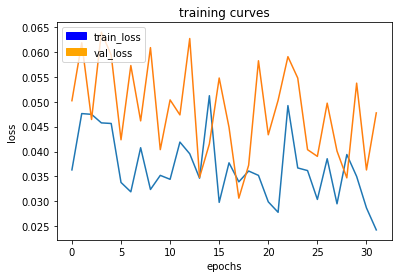

30/30 [==============================] - 87s - loss: 0.0243 - val_loss: 0.0478
Epoch 33/100
29/30 [============================>.] - ETA: 2s - loss: 0.0572

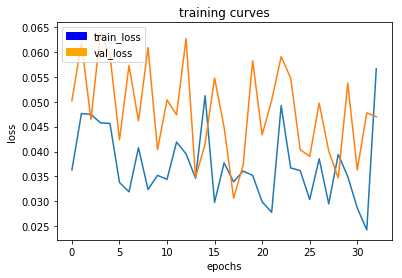

30/30 [==============================] - 89s - loss: 0.0566 - val_loss: 0.0470
Epoch 34/100
29/30 [============================>.] - ETA: 2s - loss: 0.0359

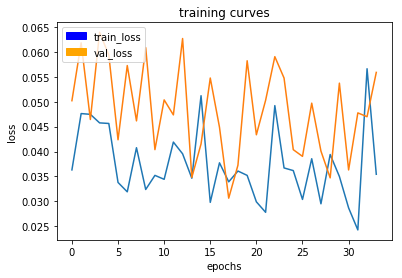

30/30 [==============================] - 92s - loss: 0.0354 - val_loss: 0.0559
Epoch 35/100
29/30 [============================>.] - ETA: 2s - loss: 0.0302

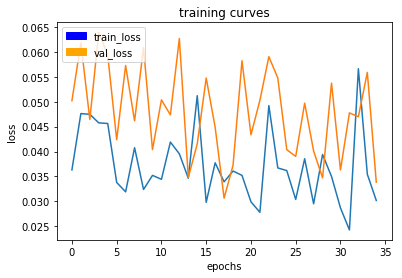

30/30 [==============================] - 90s - loss: 0.0302 - val_loss: 0.0339
Epoch 36/100
29/30 [============================>.] - ETA: 2s - loss: 0.0307

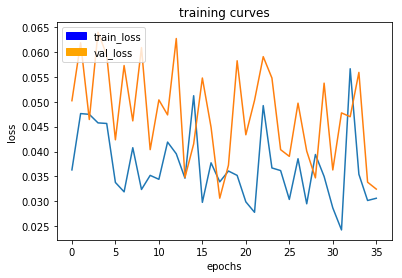

30/30 [==============================] - 92s - loss: 0.0306 - val_loss: 0.0325
Epoch 37/100
29/30 [============================>.] - ETA: 2s - loss: 0.0357

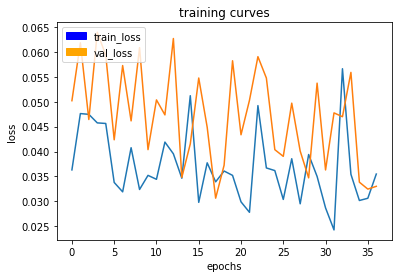

30/30 [==============================] - 88s - loss: 0.0355 - val_loss: 0.0330
Epoch 38/100
29/30 [============================>.] - ETA: 2s - loss: 0.0342

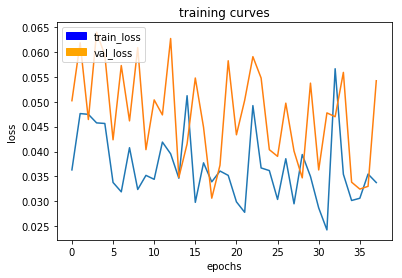

30/30 [==============================] - 89s - loss: 0.0338 - val_loss: 0.0542
Epoch 39/100
29/30 [============================>.] - ETA: 2s - loss: 0.0287

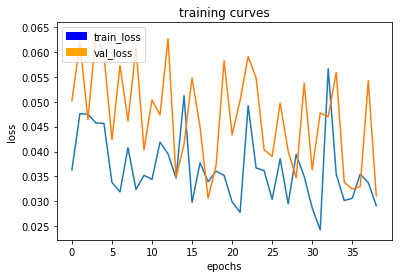

30/30 [==============================] - 88s - loss: 0.0291 - val_loss: 0.0311
Epoch 40/100
29/30 [============================>.] - ETA: 2s - loss: 0.0337

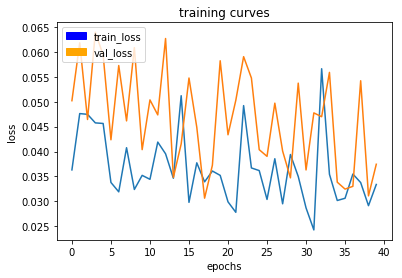

30/30 [==============================] - 87s - loss: 0.0334 - val_loss: 0.0375
Epoch 41/100
29/30 [============================>.] - ETA: 2s - loss: 0.0294

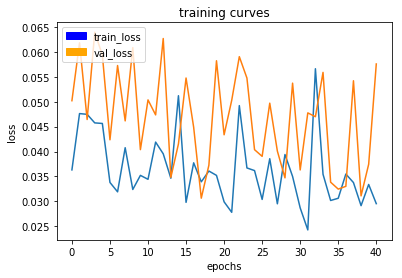

30/30 [==============================] - 89s - loss: 0.0295 - val_loss: 0.0576
Epoch 42/100
29/30 [============================>.] - ETA: 1s - loss: 0.0283

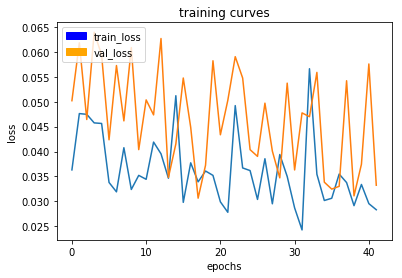

30/30 [==============================] - 86s - loss: 0.0280 - val_loss: 0.0332
Epoch 43/100
29/30 [============================>.] - ETA: 2s - loss: 0.0360

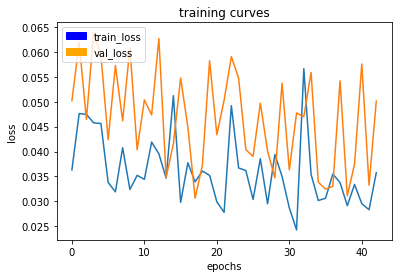

30/30 [==============================] - 87s - loss: 0.0358 - val_loss: 0.0501
Epoch 44/100
29/30 [============================>.] - ETA: 2s - loss: 0.0269

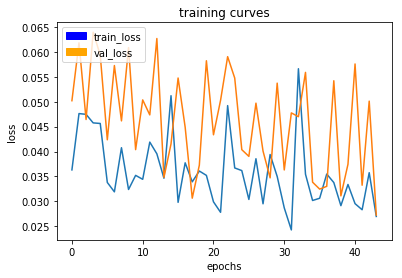

30/30 [==============================] - 89s - loss: 0.0270 - val_loss: 0.0273
Epoch 45/100
29/30 [============================>.] - ETA: 2s - loss: 0.0245

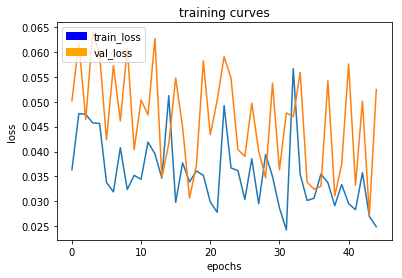

30/30 [==============================] - 91s - loss: 0.0249 - val_loss: 0.0524
Epoch 46/100
29/30 [============================>.] - ETA: 2s - loss: 0.0262

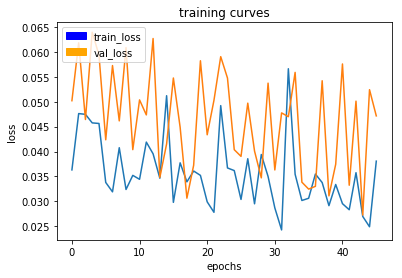

30/30 [==============================] - 99s - loss: 0.0381 - val_loss: 0.0472
Epoch 47/100
29/30 [============================>.] - ETA: 2s - loss: 0.0317

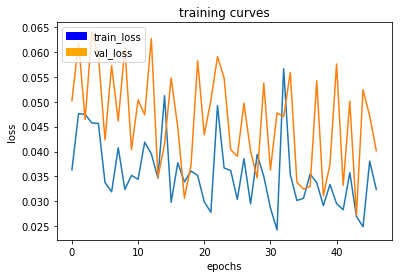

30/30 [==============================] - 93s - loss: 0.0324 - val_loss: 0.0402
Epoch 48/100
29/30 [============================>.] - ETA: 2s - loss: 0.0311

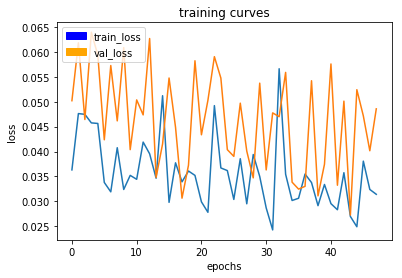

30/30 [==============================] - 98s - loss: 0.0314 - val_loss: 0.0486
Epoch 49/100
29/30 [============================>.] - ETA: 2s - loss: 0.0289

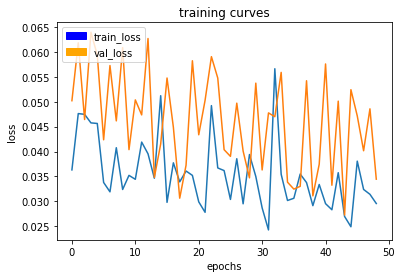

30/30 [==============================] - 89s - loss: 0.0296 - val_loss: 0.0345
Epoch 50/100
29/30 [============================>.] - ETA: 2s - loss: 0.0265

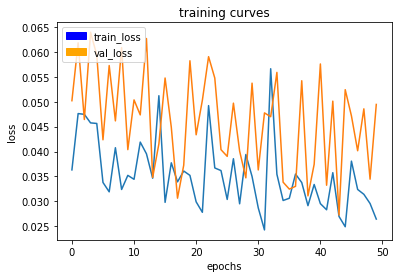

30/30 [==============================] - 95s - loss: 0.0264 - val_loss: 0.0495
Epoch 51/100
29/30 [============================>.] - ETA: 2s - loss: 0.0308

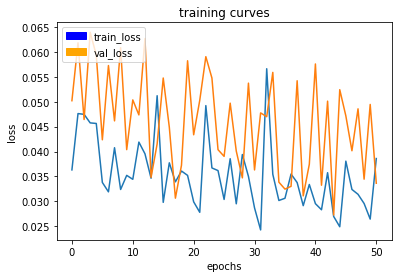

30/30 [==============================] - 100s - loss: 0.0386 - val_loss: 0.0336
Epoch 52/100
29/30 [============================>.] - ETA: 2s - loss: 0.0357

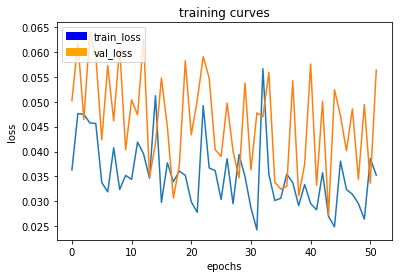

30/30 [==============================] - 90s - loss: 0.0352 - val_loss: 0.0564
Epoch 53/100
29/30 [============================>.] - ETA: 2s - loss: 0.0310

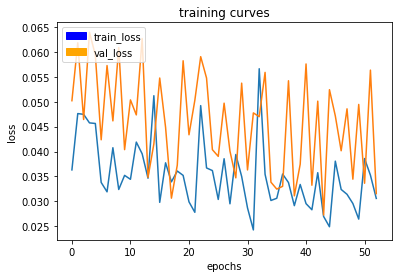

30/30 [==============================] - 109s - loss: 0.0306 - val_loss: 0.0315
Epoch 54/100
29/30 [============================>.] - ETA: 2s - loss: 0.0274

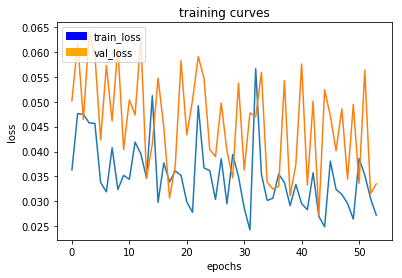

30/30 [==============================] - 95s - loss: 0.0272 - val_loss: 0.0335
Epoch 55/100
29/30 [============================>.] - ETA: 2s - loss: 0.0309

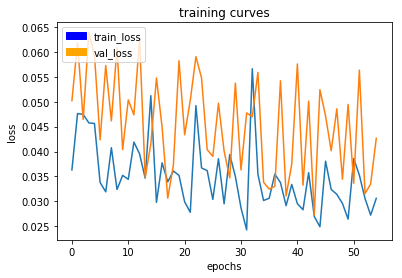

30/30 [==============================] - 97s - loss: 0.0306 - val_loss: 0.0427
Epoch 56/100
29/30 [============================>.] - ETA: 2s - loss: 0.0234

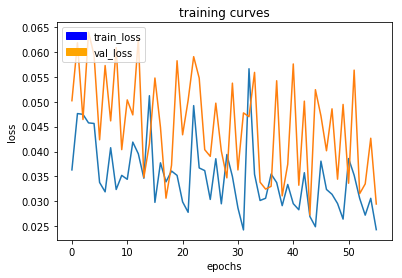

30/30 [==============================] - 91s - loss: 0.0241 - val_loss: 0.0295
Epoch 57/100
29/30 [============================>.] - ETA: 2s - loss: 0.0250

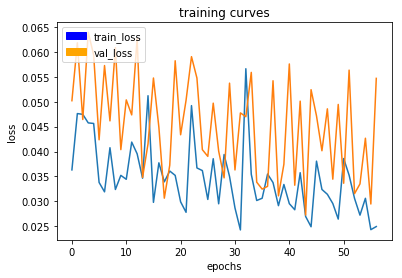

30/30 [==============================] - 92s - loss: 0.0249 - val_loss: 0.0547
Epoch 58/100
29/30 [============================>.] - ETA: 2s - loss: 0.0242

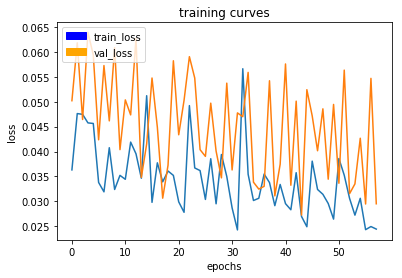

30/30 [==============================] - 106s - loss: 0.0244 - val_loss: 0.0295
Epoch 59/100
29/30 [============================>.] - ETA: 2s - loss: 0.0339

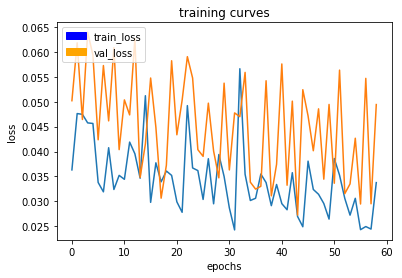

30/30 [==============================] - 108s - loss: 0.0338 - val_loss: 0.0494
Epoch 60/100
29/30 [============================>.] - ETA: 2s - loss: 0.0330

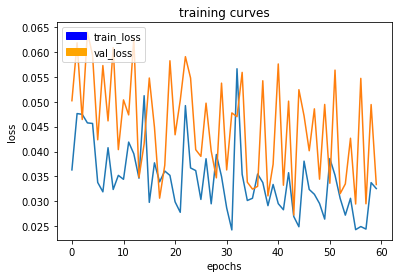

30/30 [==============================] - 89s - loss: 0.0326 - val_loss: 0.0334
Epoch 61/100
29/30 [============================>.] - ETA: 2s - loss: 0.0295

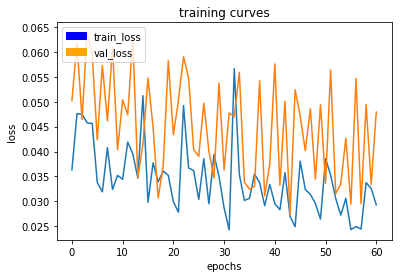

30/30 [==============================] - 99s - loss: 0.0293 - val_loss: 0.0479
Epoch 62/100
29/30 [============================>.] - ETA: 2s - loss: 0.0282

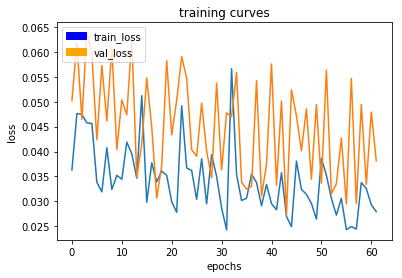

30/30 [==============================] - 93s - loss: 0.0279 - val_loss: 0.0381
Epoch 63/100
29/30 [============================>.] - ETA: 2s - loss: 0.0291

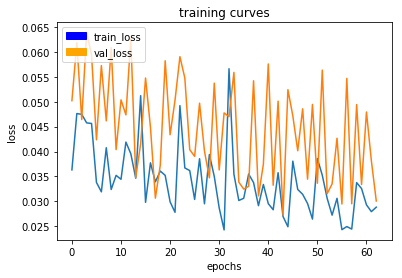

30/30 [==============================] - 89s - loss: 0.0288 - val_loss: 0.0301
Epoch 64/100
29/30 [============================>.] - ETA: 2s - loss: 0.0327

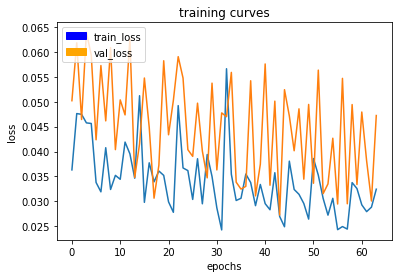

30/30 [==============================] - 87s - loss: 0.0324 - val_loss: 0.0472
Epoch 65/100
29/30 [============================>.] - ETA: 2s - loss: 0.0298

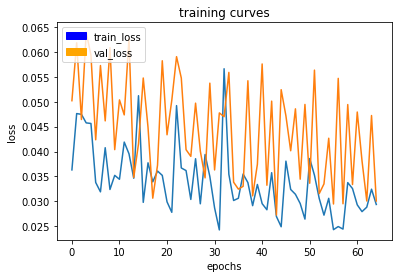

30/30 [==============================] - 87s - loss: 0.0294 - val_loss: 0.0301
Epoch 66/100
29/30 [============================>.] - ETA: 2s - loss: 0.0389

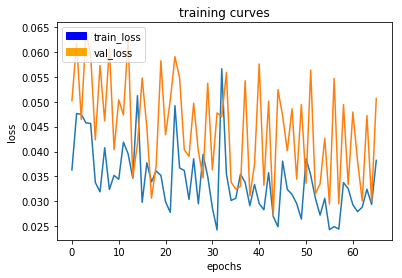

30/30 [==============================] - 88s - loss: 0.0382 - val_loss: 0.0506
Epoch 67/100
29/30 [============================>.] - ETA: 2s - loss: 0.0352

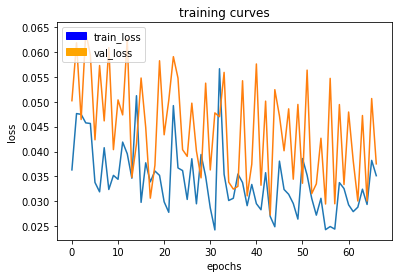

30/30 [==============================] - 87s - loss: 0.0352 - val_loss: 0.0375
Epoch 68/100
29/30 [============================>.] - ETA: 2s - loss: 0.0347

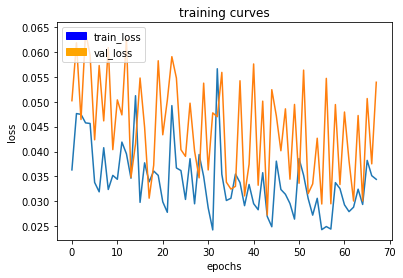

30/30 [==============================] - 89s - loss: 0.0344 - val_loss: 0.0539
Epoch 69/100
29/30 [============================>.] - ETA: 1s - loss: 0.0252

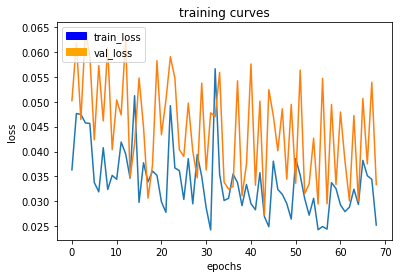

30/30 [==============================] - 85s - loss: 0.0253 - val_loss: 0.0334
Epoch 70/100
29/30 [============================>.] - ETA: 2s - loss: 0.0299

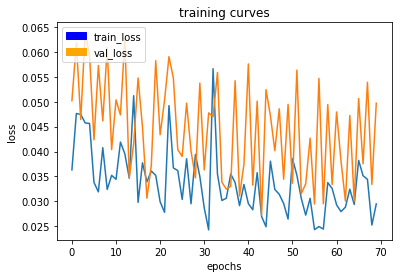

30/30 [==============================] - 87s - loss: 0.0295 - val_loss: 0.0497
Epoch 71/100
29/30 [============================>.] - ETA: 2s - loss: 0.0411

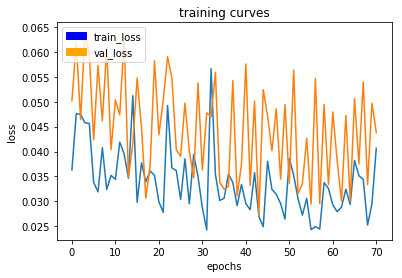

30/30 [==============================] - 90s - loss: 0.0407 - val_loss: 0.0438
Epoch 72/100
29/30 [============================>.] - ETA: 2s - loss: 0.0356

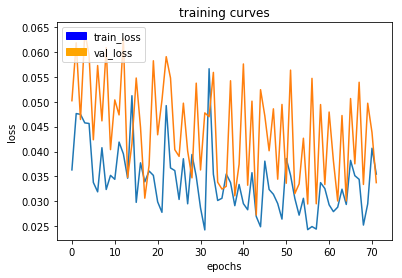

30/30 [==============================] - 94s - loss: 0.0355 - val_loss: 0.0338
Epoch 73/100
29/30 [============================>.] - ETA: 2s - loss: 0.0309

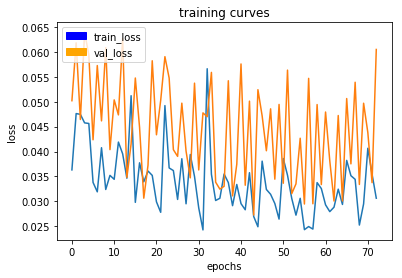

30/30 [==============================] - 89s - loss: 0.0306 - val_loss: 0.0605
Epoch 74/100
29/30 [============================>.] - ETA: 2s - loss: 0.0265

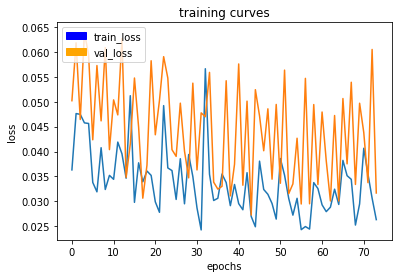

30/30 [==============================] - 88s - loss: 0.0263 - val_loss: 0.0317
Epoch 75/100
29/30 [============================>.] - ETA: 2s - loss: 0.0331

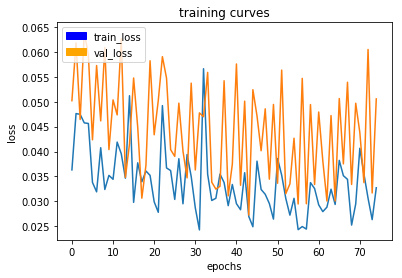

30/30 [==============================] - 86s - loss: 0.0327 - val_loss: 0.0506
Epoch 76/100
29/30 [============================>.] - ETA: 2s - loss: 0.0245

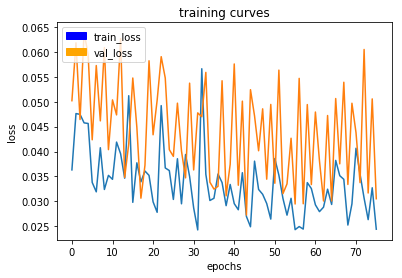

30/30 [==============================] - 87s - loss: 0.0244 - val_loss: 0.0305
Epoch 77/100
29/30 [============================>.] - ETA: 2s - loss: 0.0259

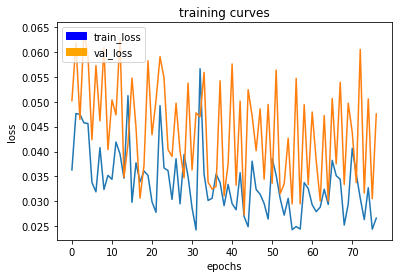

30/30 [==============================] - 86s - loss: 0.0266 - val_loss: 0.0475
Epoch 78/100
29/30 [============================>.] - ETA: 2s - loss: 0.0258

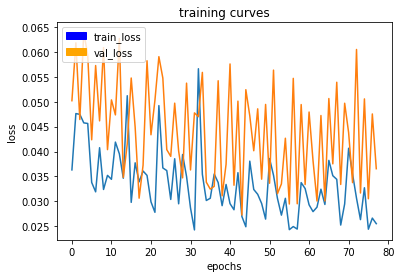

30/30 [==============================] - 87s - loss: 0.0255 - val_loss: 0.0366
Epoch 79/100
29/30 [============================>.] - ETA: 2s - loss: 0.0262

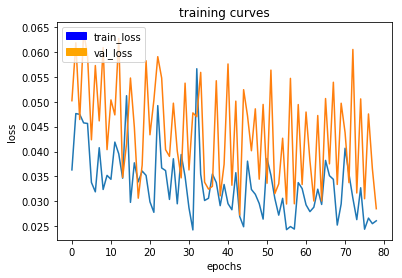

30/30 [==============================] - 87s - loss: 0.0261 - val_loss: 0.0285
Epoch 80/100
29/30 [============================>.] - ETA: 2s - loss: 0.0256

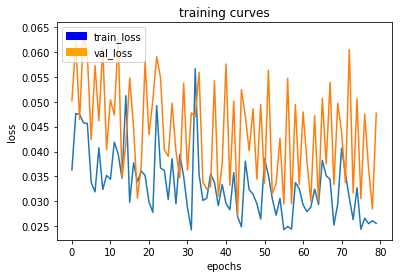

30/30 [==============================] - 87s - loss: 0.0256 - val_loss: 0.0477
Epoch 81/100
29/30 [============================>.] - ETA: 2s - loss: 0.0237

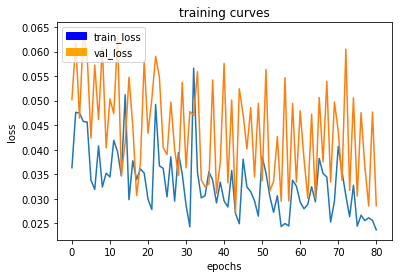

30/30 [==============================] - 87s - loss: 0.0236 - val_loss: 0.0286
Epoch 82/100
29/30 [============================>.] - ETA: 2s - loss: 0.0253

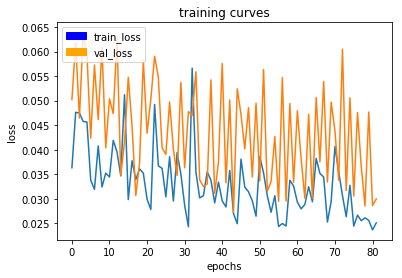

30/30 [==============================] - 89s - loss: 0.0251 - val_loss: 0.0299
Epoch 83/100
29/30 [============================>.] - ETA: 1s - loss: 0.0376

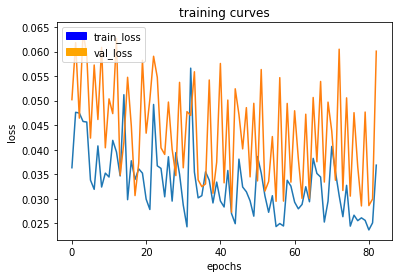

30/30 [==============================] - 86s - loss: 0.0374 - val_loss: 0.0601
Epoch 84/100
29/30 [============================>.] - ETA: 2s - loss: 0.0264

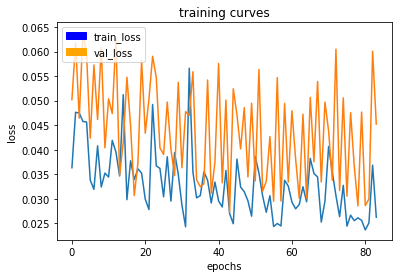

30/30 [==============================] - 88s - loss: 0.0262 - val_loss: 0.0452
Epoch 85/100
29/30 [============================>.] - ETA: 2s - loss: 0.0312

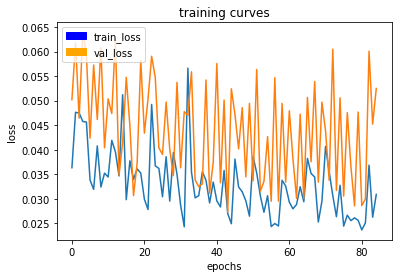

30/30 [==============================] - 90s - loss: 0.0309 - val_loss: 0.0525
Epoch 86/100
29/30 [============================>.] - ETA: 2s - loss: 0.0357

In [ ]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [75]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [76]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.
# Define the Keras model and compile it for training
#model = models.Model(inputs=inputs, outputs=output_layer)

weight_file_name = 'model_weights'
restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [77]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

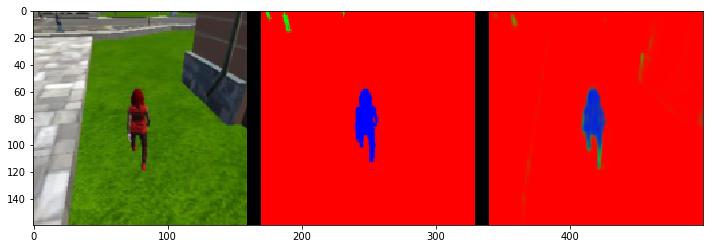

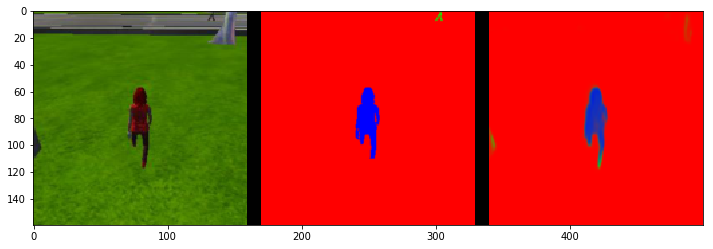

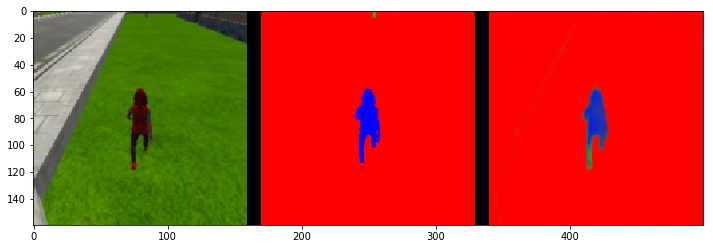

In [78]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

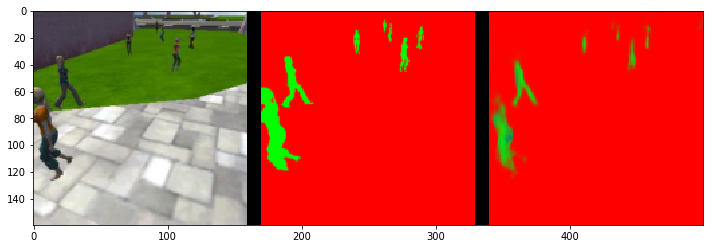

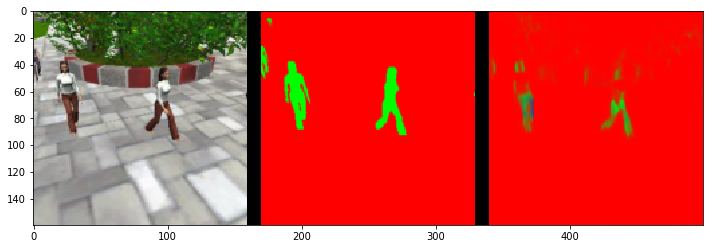

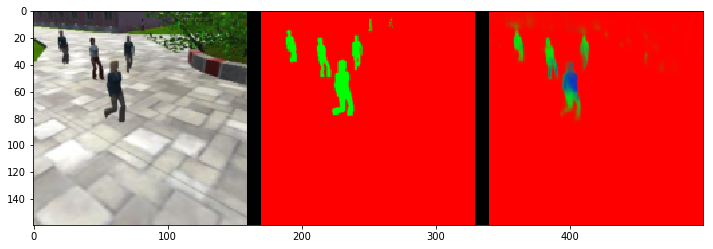

In [79]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

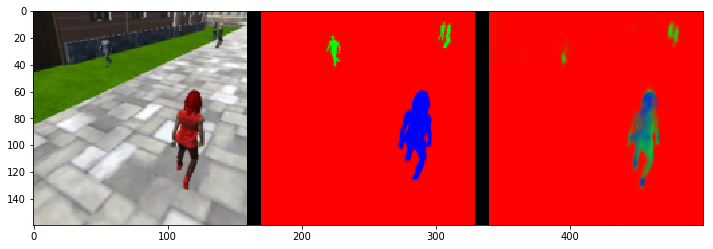

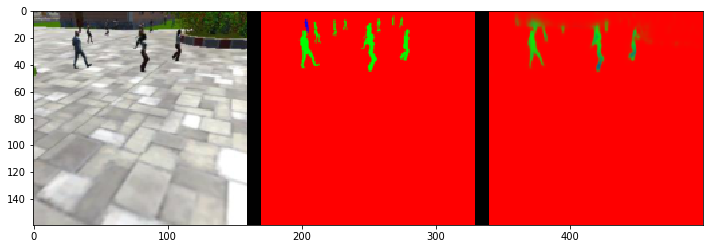

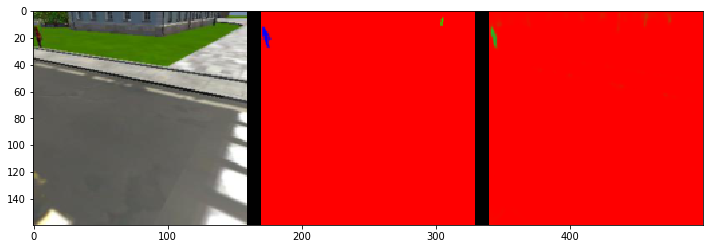

In [80]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [81]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9910554724964684
average intersection over union for other people is 0.10894890179003872
average intersection over union for the hero is 0.7087456279145052
number true positives: 539, number false positives: 0, number false negatives: 0


In [82]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9666510172139046
average intersection over union for other people is 0.23189546008164028
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 64, number false negatives: 0


In [83]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.993744330484928
average intersection over union for other people is 0.1898389890400754
average intersection over union for the hero is 0.02899468688780117
number true positives: 47, number false positives: 1, number false negatives: 254


In [84]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.6475138121546962


In [85]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.3688701574011532


In [86]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.23884852180892352
